<a href="https://colab.research.google.com/github/ShkoJ/ShkoJ-Dog-Breed-Classification-Project/blob/main/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end Mutli-Class Dog Breed Claasification

This notebook build an end-to-end multiClass image calssifier using Tensorflow and Tensorflow Hub.


## 1. Problem
Identifying the breed of a dog given an image of a dog.

## 2. Data
The data we're using is from Kaggle's dog breed identification competition.
https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation
The evaluation is a file with prediction probabilities for each dog breed of each test image.
www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

## 4. Features
Some info about the data:
* We're dealing with images, so its probably best if we used deep learning/transfer learning.
* There are 120 Breeds of dogs (120 different classed).
* There are around 10,000+ images in the Training set (these images have labels).
* There are around 10,000+ images in the Testing set (these images do NOT have labels because we'll want to predict them).



### Getting our workspace ready

* Import TensorFlow
* Import TensorFlow Hub
* Make sure to use a GPU

In [ ]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "available (yay)" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.18.0
TF Hub version: 0.16.1
GPU available (yay)


## Getting our data ready (turning into tensors)

With all machine learining models, our data has to be in numerical format. so that's what we'll be doing first. Turning our images into tensors (numerical repersentations.

In [ ]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/My Drive/Dog Vision/labels.csv")
labels_csv.head()
labels_csv.tail()


,id,breed
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher
10221,fff43b07992508bc822f33d8ffd902ae,chesapeake_bay_retriever


In [ ]:
# How many images are there of each breed
labels_csv["breed"].value_counts()
labels_csv["breed"].value_counts().median()

82.0

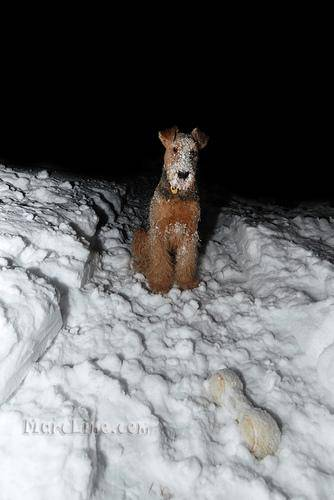

In [ ]:
# Let's view an image
from IPython.display import display, Image
Image("drive/My Drive/Dog Vision/train/ffe2ca6c940cddfee68fa3cc6c63213f.jpg")

## Getting images and thier labels

Let's get a list of all of our images file pathnames.

In [ ]:
# Create pathnames from image ID's
filenames = ["drive/My Drive/Dog Vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]
# Check the first 10
filenames[:10]

['drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [ ]:
# Check wether number of filenames matches number of actual image files
import os
if len(os.listdir("drive/My Drive/Dog Vision/train/")) == len(filenames):
  print("Filenames match actual amount of files")
else:
  print("Filenames do not match actual amount of files")

Filenames match actual amount of files


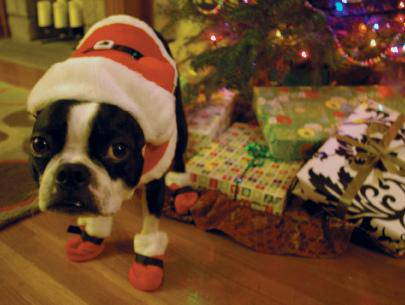

In [ ]:
# One final check to see our data is set up
Image(filenames[924])

since we've got our training filepaths in a list, let's prepare our labels

In [ ]:
import numpy as np
labels = labels_csv["breed"]
labels = np.array(labels)
len(labels)

10222

In [ ]:
# Check if number of labels matches number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames")
else:
  print("Number of labels does not match number of filenames")

Number of labels matches number of filenames


In [ ]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)


120

In [ ]:
# Turn every label into a boolean array
boolean_labels = [label == np.array(unique_breeds) for label in labels]
boolean_labels[:2]
len(boolean_labels)

10222

In [ ]:
# Example to see if it works
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set
Since the data from kaggle doesn't provide a validation set we'll have to create our own

In [ ]:
# Setup x & y variables
x = filenames
y = boolean_labels
# We're going to start off experimenting with 1000 images and increase as needed
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:500}

In [ ]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
x_train, x_val, y_train, y_val = train_test_split(x[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)
len(x_train), len(x_val), len(y_train), len(y_val)

(800, 200, 800, 200)

In [ ]:
# Let's take a look at our training data
x_train[:5], y_train[:2]

(['drive/My Drive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/My Drive/Dog Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/My Drive/Dog Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/My Drive/Dog Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, Fa

## Preprocessing images (turning images into Tensors)
To preprocess our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, 'image'
3. Turn our 'image' (a jpg) into Tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1 for a more efficient computing)
5. Resize the 'image' to be a shape of (244, 244)
6. Return the modified 'image'

In [ ]:
# Define image size
IMG_SIZE = 224

def preprocess_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensors with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (244, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image



## Turning our data into batches

We turn our data into batches (32 batch size) so that it fits into memory.

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which looks something like this: '(image, label)'

In [ ]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = preprocess_image(image_path)
  return image, label

In [ ]:
# Demo of the above
get_image_label(x[42], y[42])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

In [ ]:
# Now that we have made our data into tuples of Tensors lets create a function to turn data into batches
BATCH_SIZE = 32

# Function
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is Test dataset, we don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(preprocess_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)

  return data_batch



In [ ]:
# Create training and validation data batches
train_data = create_data_batches(x_train, y_train)
val_data = create_data_batches(x_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [ ]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches
our data is now in batches, however it can be alittle hard to understand, so lets visualize it.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays 25 images from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))  # set figure size

  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")


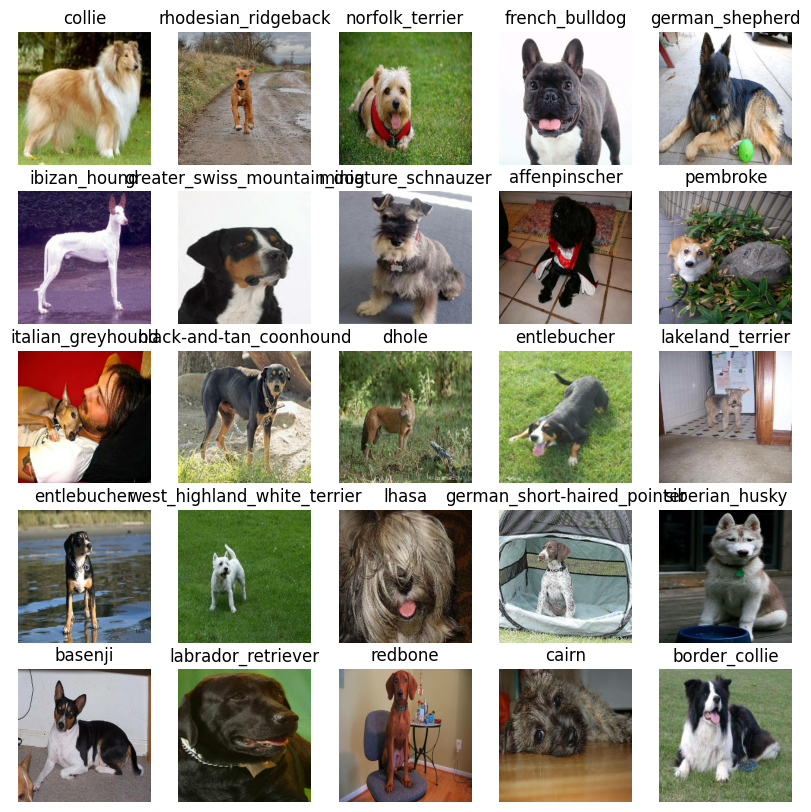

In [ ]:
# Now let's visualize our data in the batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

## Building a model

Before we build a model, there are a few things we need to define:
* The input shape (our image shape, in the form of Tensors)
* The output shape (our labels, in the form of Tensors)
* The URL of the model we want to use "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4".

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

def create_model(input_shape=(224, 224, 3), output_shape=120):
    """
    Creates a model using MobileNetV2 as base with custom top layers.
    """
    # Load the base model (pre-trained on ImageNet)
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet',
        pooling='avg'  # GlobalAveragePooling at the end
    )

    # Freeze the base model
    base_model.trainable = False

    # Create new model on top
    inputs = layers.Input(shape=input_shape)

    # Preprocess input (MobileNetV2 expects inputs in [-1, 1] range)
    # Updated preprocessing for newer TF versions
    x = layers.Rescaling(scale=1./127.5, offset=-1)(inputs)

    # The base model contains batchnorm layers. We want to keep them in inference mode
    x = base_model(x, training=False)

    # Add a dense layer on top
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    # Output layer
    outputs = layers.Dense(output_shape, activation='softmax')(x)

    # Combine all
    model = models.Model(inputs, outputs)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create model
model = create_model()
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 1280)                │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 120)                 │          61,560 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,975,416 (11.35 MB)

 Trainable params: 717,432 (2.74 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2
import numpy as np

# 1. FIX DATA PREPROCESSING ---------------------------------------------------
def process_image(image_path, img_size=224):
    """Properly preprocess image for MobileNetV2"""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_size, img_size])
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)  # Critical change!
    return image

def get_image_label(image_path, label):
    """Ensure labels are properly formatted"""
    image = process_image(image_path)
    return image, tf.one_hot(label, depth=120)  # Convert to proper one-hot encoding

# 2. REBUILD MODEL WITH BETTER ARCHITECTURE -----------------------------------
def create_improved_model():
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )
    base_model.trainable = False  # Freeze initially

    inputs = layers.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)

    # Enhanced top layers
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(120, activation='softmax')(x)

    model = models.Model(inputs, outputs)

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# 3. PREPARE DATA PROPERLY ---------------------------------------------------
# Convert labels to integer indices first
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_int = le.fit_transform([label[0] for label in y_train])  # Assuming y_train is list of arrays
y_val_int = le.transform([label[0] for label in y_val])

# Create datasets with proper preprocessing
def create_data_batches(X, y, batch_size=32, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X))
    dataset = dataset.map(get_image_label, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_data = create_data_batches(x_train, y_train_int, shuffle=True)
val_data = create_data_batches(x_val, y_val_int)

# 4. TRAIN WITH CALLBACKS ----------------------------------------------------
model = create_improved_model()

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
]

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=callbacks
)

# 5. FINE-TUNING PHASE ------------------------------------------------------
# Unfreeze some base layers after initial training
base_model = model.layers[1]
base_model.trainable = True

# Fine-tune from this layer onwards
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.00001),  # Very low LR
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    initial_epoch=history.epoch[-1] + 1,
    callbacks=callbacks
)

# 6. EVALUATION -------------------------------------------------------------
# Convert test labels if needed
y_test_int = le.transform([label[0] for label in y_test]) if 'y_test' in locals() else None

test_data = create_data_batches(x_test, y_test_int) if 'X_test' in locals() else None

if test_data:
    test_loss, test_acc = model.evaluate(test_data)
    print(f"\nTest accuracy: {test_acc*100:.2f}%")

# Save final model
model.save('dog_breed_classifier_final.keras')

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 381s 15s/step - accuracy: 0.0489 - loss: 4.5748 - val_accuracy: 0.3050 - val_loss: 3.9588 - learning_rate: 1.0000e-04
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 236ms/step - accuracy: 0.3466 - loss: 2.7550 - val_accuracy: 0.9500 - val_loss: 3.1620 - learning_rate: 1.0000e-04
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 0.7848 - loss: 1.3000 - val_accuracy: 0.9900 - val_loss: 2.4441 - learning_rate: 1.0000e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 241ms/step - accuracy: 0.9479 - loss: 0.6056 - val_accuracy: 0.9950 - val_loss: 1.8161 - learning_rate: 1.0000e-04
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.9882 - loss: 0.2801 - val_accuracy: 0.9950 - val_loss: 1.2858 - learning_rate: 1.0000e-04
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - accuracy: 0.9916 - loss: 0.1553 - val_accuracy: 0.9950 - val_loss: 0.9130 - learning_rate: 1.0000e-04
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy:


Found 2 potential duplicate/similar image pairs:
04c3bdfec0c7f082c7e697c26be9e020.jpg is similar to 0a541df84dd3febb076e2c33a23cd230.jpg
07751d1687e0233ff638889d8b365709.jpg is similar to 04fb4d719e9fe2b6ffe32d9ae7be8a22.jpg

Visualizing first duplicate pair:


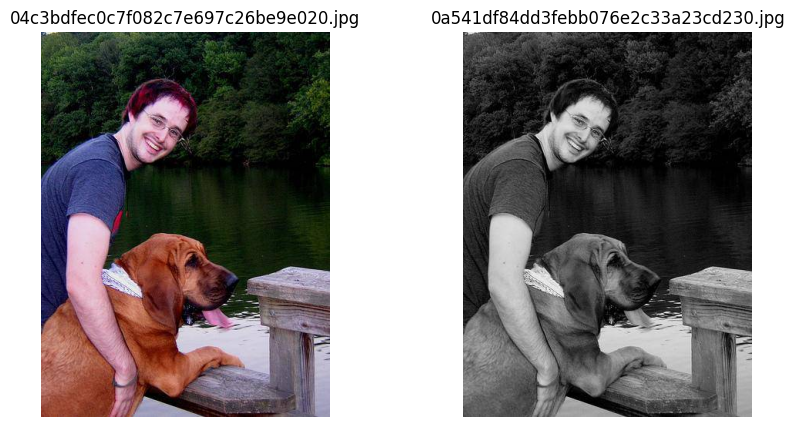

In [ ]:
!pip install imagehash
from PIL import Image
import imagehash
import os

def find_duplicates(image_paths, hash_size=8):
    """
    Find duplicate/similar images in a dataset

    Args:
        image_paths: List of paths to images
        hash_size: Size of hash to use (larger = more sensitive)

    Returns:
        List of duplicate pairs (path1, path2)
    """
    hashes = {}
    duplicates = []

    for path in image_paths:
        try:
            with Image.open(path) as img:
                # Convert to grayscale and resize for consistent hashing
                img = img.convert("L").resize((hash_size, hash_size), Image.LANCZOS)
                h = imagehash.average_hash(img)

            if h in hashes:
                duplicates.append((path, hashes[h]))
            else:
                hashes[h] = path
        except Exception as e:
            print(f"Error processing {path}: {e}")

    return duplicates

# Check train/val duplicates (use your actual variable names)
all_images = x_train + x_val  # Make sure these are your actual variables
duplicates = find_duplicates(all_images)

print(f"\nFound {len(duplicates)} potential duplicate/similar image pairs:")
for pair in duplicates[:10]:  # Print first 10 duplicates
    print(f"{os.path.basename(pair[0])} is similar to {os.path.basename(pair[1])}")

# Visualize some duplicates
import matplotlib.pyplot as plt

if len(duplicates) > 0:
    print("\nVisualizing first duplicate pair:")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    img1 = Image.open(duplicates[0][0])
    img2 = Image.open(duplicates[0][1])

    ax1.imshow(img1)
    ax1.set_title(os.path.basename(duplicates[0][0]))
    ax1.axis('off')

    ax2.imshow(img2)
    ax2.set_title(os.path.basename(duplicates[0][1]))
    ax2.axis('off')

    plt.show()
else:
    print("No duplicates found!")

In [ ]:
def create_data_batches(X, y=None, batch_size=32, is_test=False):
    """
    Creates batches of data from image paths.

    Args:
        X: List of image paths
        y: Corresponding labels (None for test data)
        batch_size: Size of batches
        is_test: Boolean indicating test data
    """
    if is_test:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices(tf.constant(X))
        data = data.map(process_image)
    else:
        print("Creating training/validation batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                 tf.constant(y)))
        data = data.map(get_image_label)
        data = data.shuffle(buffer_size=len(X))

    return data.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Get test filenames
test_dir = "drive/MyDrive/Dog Vision/test"
test_filenames = [os.path.join(test_dir, fname)
                 for fname in os.listdir(test_dir)
                 if fname.endswith('.jpg')]

# Create test batches
test_data = create_data_batches(test_filenames, is_test=True)

# Make predictions
test_predictions = model.predict(test_data)
print(f"Predicted {len(test_predictions)} test images")

Creating test data batches...
324/324 ━━━━━━━━━━━━━━━━━━━━ 1982s 6s/step
Predicted 10357 test images
